# **Super Resolution**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

## Make paths and download data

In [0]:
!mkdir data

In [0]:
!mkdir data/'images'

In [0]:
folder = 'images'
file = 'urls.txt'

In [0]:
path = Path('data')
path.mkdir(parents = True, exist_ok = True)

In [0]:
download_images(path/file, path/folder)

# Download COCO and set paths there

In [0]:
path = Path('data')
path.mkdir(parents = True, exist_ok = True)

In [0]:
%cd "/content/data/images"
!wget https://s3.amazonaws.com/fast-ai-coco/train2017.zip

/content/data/images
--2019-11-14 13:41:27--  https://s3.amazonaws.com/fast-ai-coco/train2017.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.24.134
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.24.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  36.7MB/s    in 8m 38s  

2019-11-14 13:50:06 (35.6 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [0]:
!unzip /content/data/images/train2017.zip -d /content/data/images/

In [0]:
# !ls /content/data/images/train2017 | head -10
!ls /content/data/images/train2017|wc -l

118287


## Remove invalid images

In [0]:
folder = 'images'

In [0]:
verify_images(path/folder, delete=True, max_workers=8)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path/folder, train = ".", valid_pct = 0.2, ds_tfms = get_transforms(), size = 224, num_workers = 4).normalize(imagenet_stats)

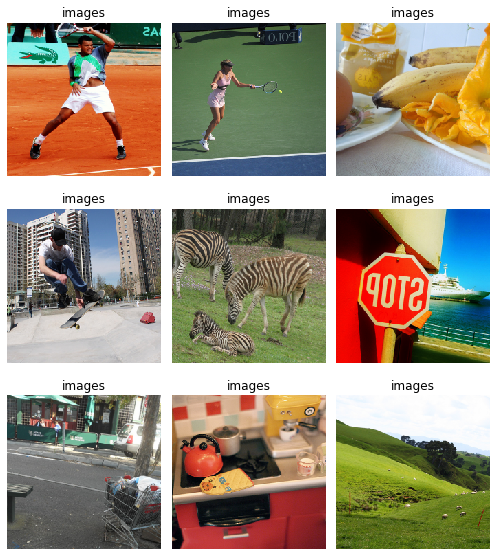

In [22]:
data.show_batch(rows = 3, figsize = (7,8))

# Other paths and resize

In [0]:
path_hr = path/'images'
path_lr = path/'crappy'

In [0]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

In [0]:
bs, size = 32, 128
arch = models.resnet34

# Pre train gen

In [0]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1 , seed = 42)

In [0]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
    .transform(get_transforms(max_zoom=2.),size = size, tfm_y = True)
    .databunch(bs = bs)
    .normalize(imagenet_stats, do_y = True)
    )
    data.c = 3
    return data

In [0]:
data_gen = get_data(bs, size)

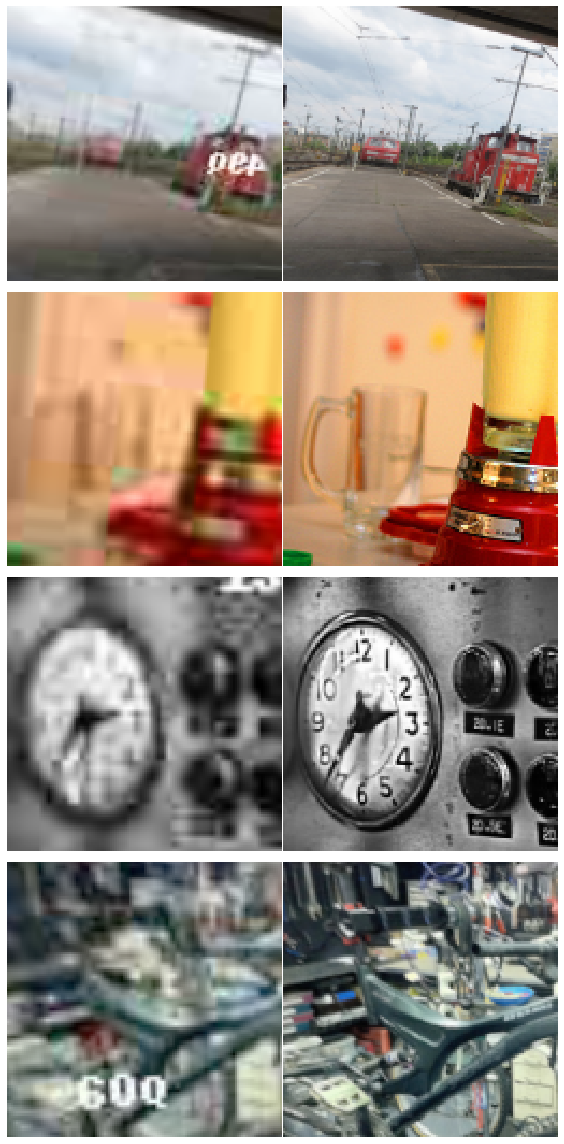

In [29]:
data_gen.show_batch(4)

In [0]:
wd = 1e-3
y_range = (-3., 3.)

In [0]:
loss_gen = MSELossFlat()

In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd = wd, blur = True, norm_type = NormType.Weight, 
                        self_attention = True, y_range = y_range, loss_func = loss_gen)

In [33]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 19.1MB/s]


In [34]:
learn_gen.fit_one_cycle(2, pct_start = 0.8)

In [0]:
learn_gen.save('stage-1')

In [0]:
learn_gen.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


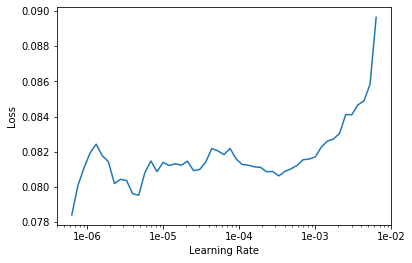

In [37]:
learn_gen.lr_find()
learn_gen.recorder.plot()

In [0]:
learn_gen.unfreeze()

In [39]:
learn_gen.fit_one_cycle(5, slice(1e-4,5e-4))

In [0]:
learn_gen.save('stage-2')

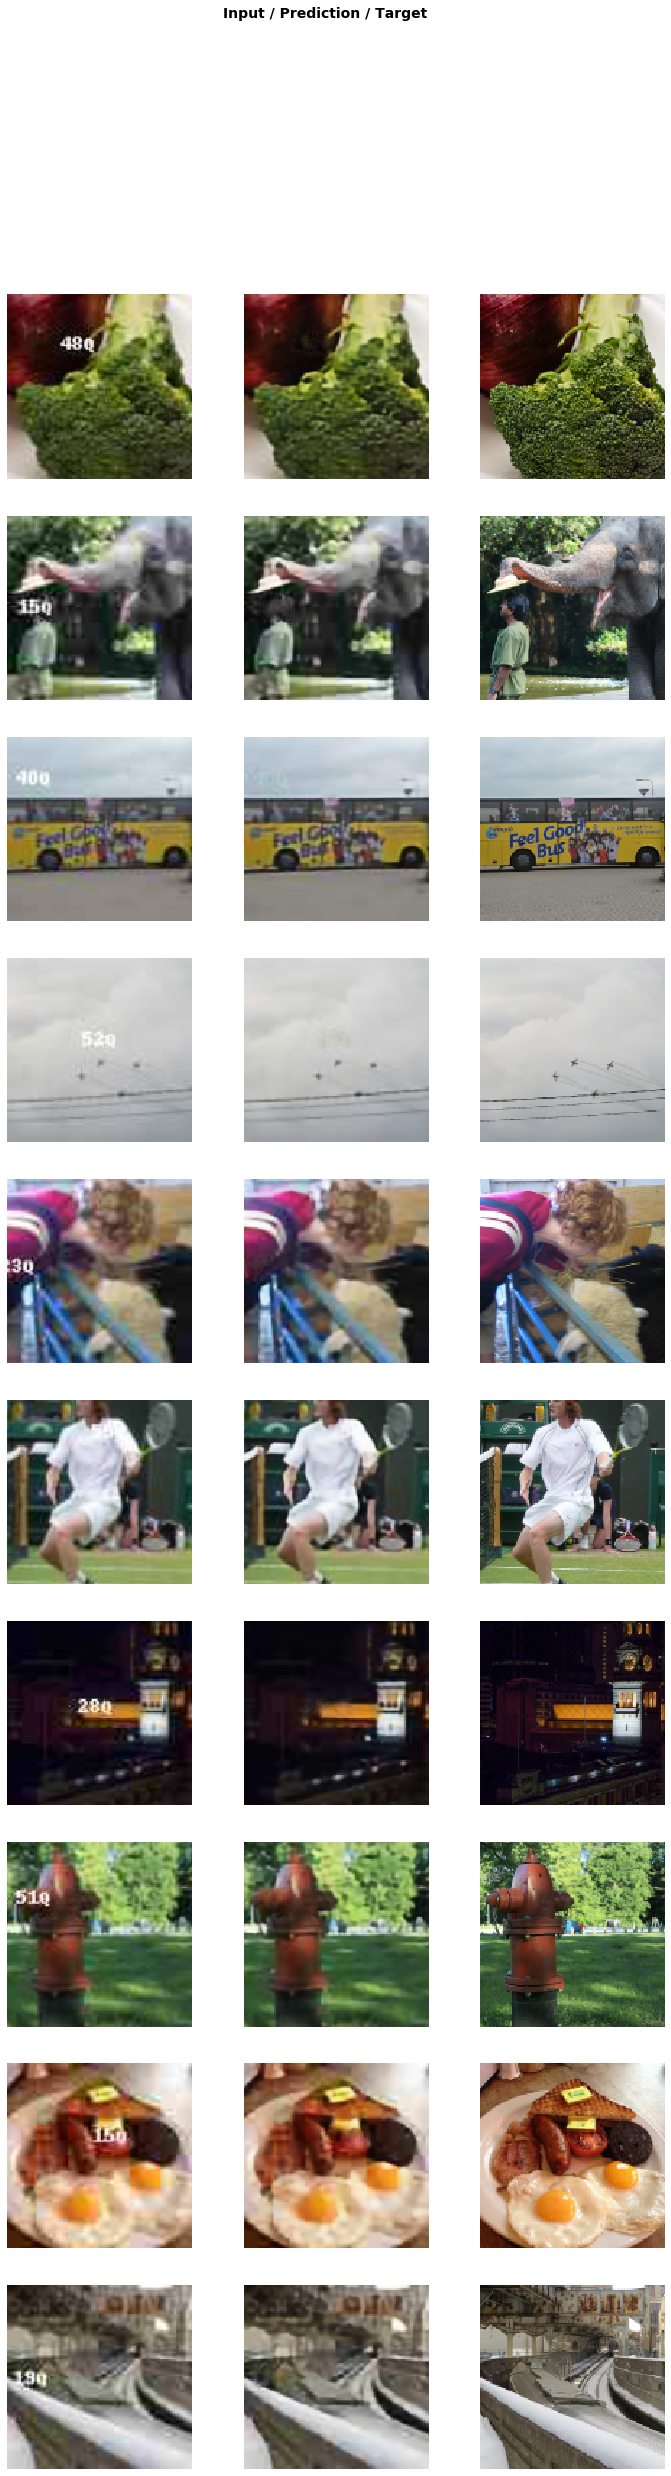

In [41]:
learn_gen.show_results(rows = 10)

In [0]:
learn_gen.save('gen-pre2')

## Save gen images

In [43]:
learn_gen.load('gen-pre2')

Learner(data=ImageDataBunch;

Train: LabelList (5400 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /content/data/crappy;

Valid: LabelList (600 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /content/data/crappy;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequentia

In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    i = 0
    names = dl.dataset.items
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i+=1

In [0]:
save_preds(data_gen.fix_dl)

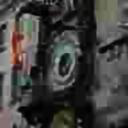

In [48]:
PIL.Image.open(path_gen.ls()[0])t

## Train critic

In [49]:
learn_gen=None
gc.collect()

567

## Pretrain critic on crappy vs non crappy

In [0]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include = classes).split_by_rand_pct(0.1, seed =42)
    ll = src.label_from_folder(classes = classes)
    data = (ll.transform(get_transforms(max_zoom=2.),size = size)
    .databunch(bs = bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [0]:
data_crit = get_crit_data([name_gen,'images'],bs = bs, size = size)

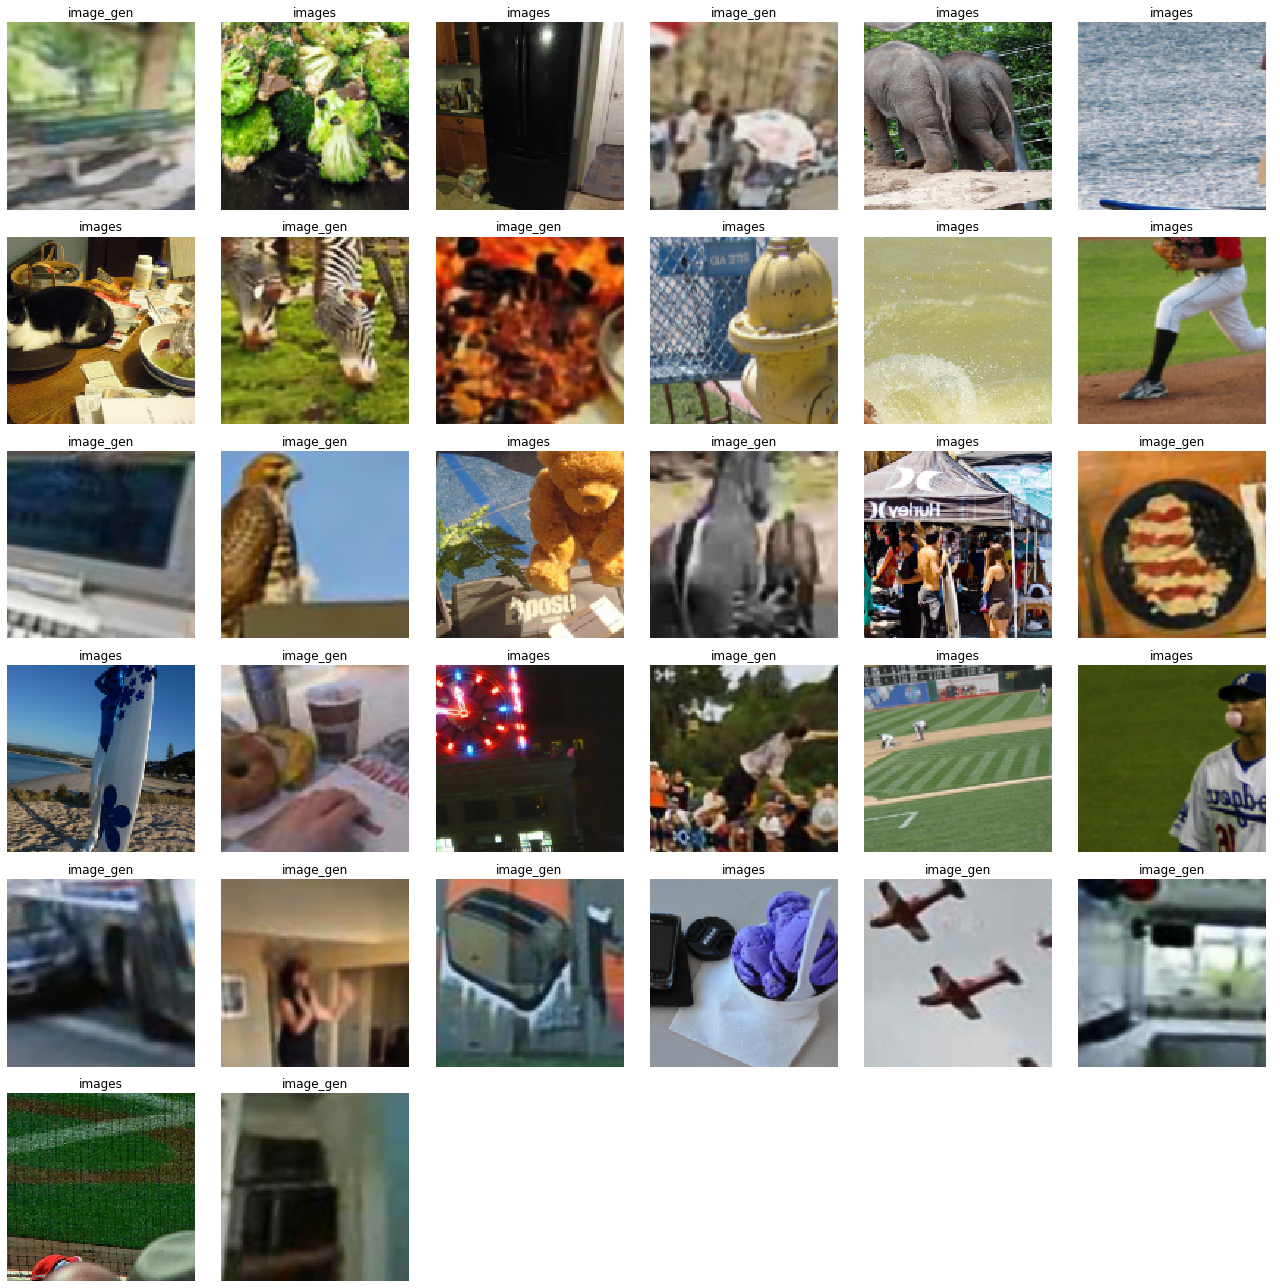

In [61]:
data_crit.show_batch(rows=10, ds_type=DatasetType.Train, imgsize=3)

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [0]:
def create_critic_learner(data, metrics):
    return Learner(data,gan_critic(),metrics = metrics, loss_func=loss_critic,wd =wd)

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [63]:
learn_critic.fit_one_cycle(6)

In [0]:
learn_critic.save('critic-pre2-0')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


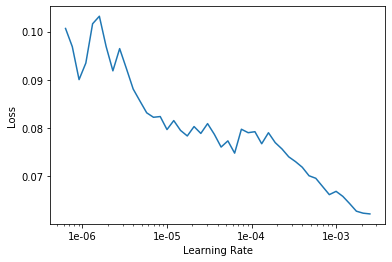

In [64]:
learn_critic.unfreeze()
learn_critic.lr_find()
learn_critic.recorder.plot()

In [0]:
learn_critic.unfreeze()
learn_critic.fit_one_cycle(4, 2e-4)

In [0]:
learn_critic.save('critic-pre2-1')

# GAN

In [67]:
learn_crit=None
learn_gen=None
gc.collect()

5770

In [0]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2-0')

In [0]:
learn_gen = create_gen_learner().load('gen-pre2')

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
lr = 1e-4

In [76]:
learn.fit(3,lr)

In [0]:
learn.save('gan-1c')

In [88]:
learn.fit(10,lr)

In [0]:
learn.save('gan-2c')

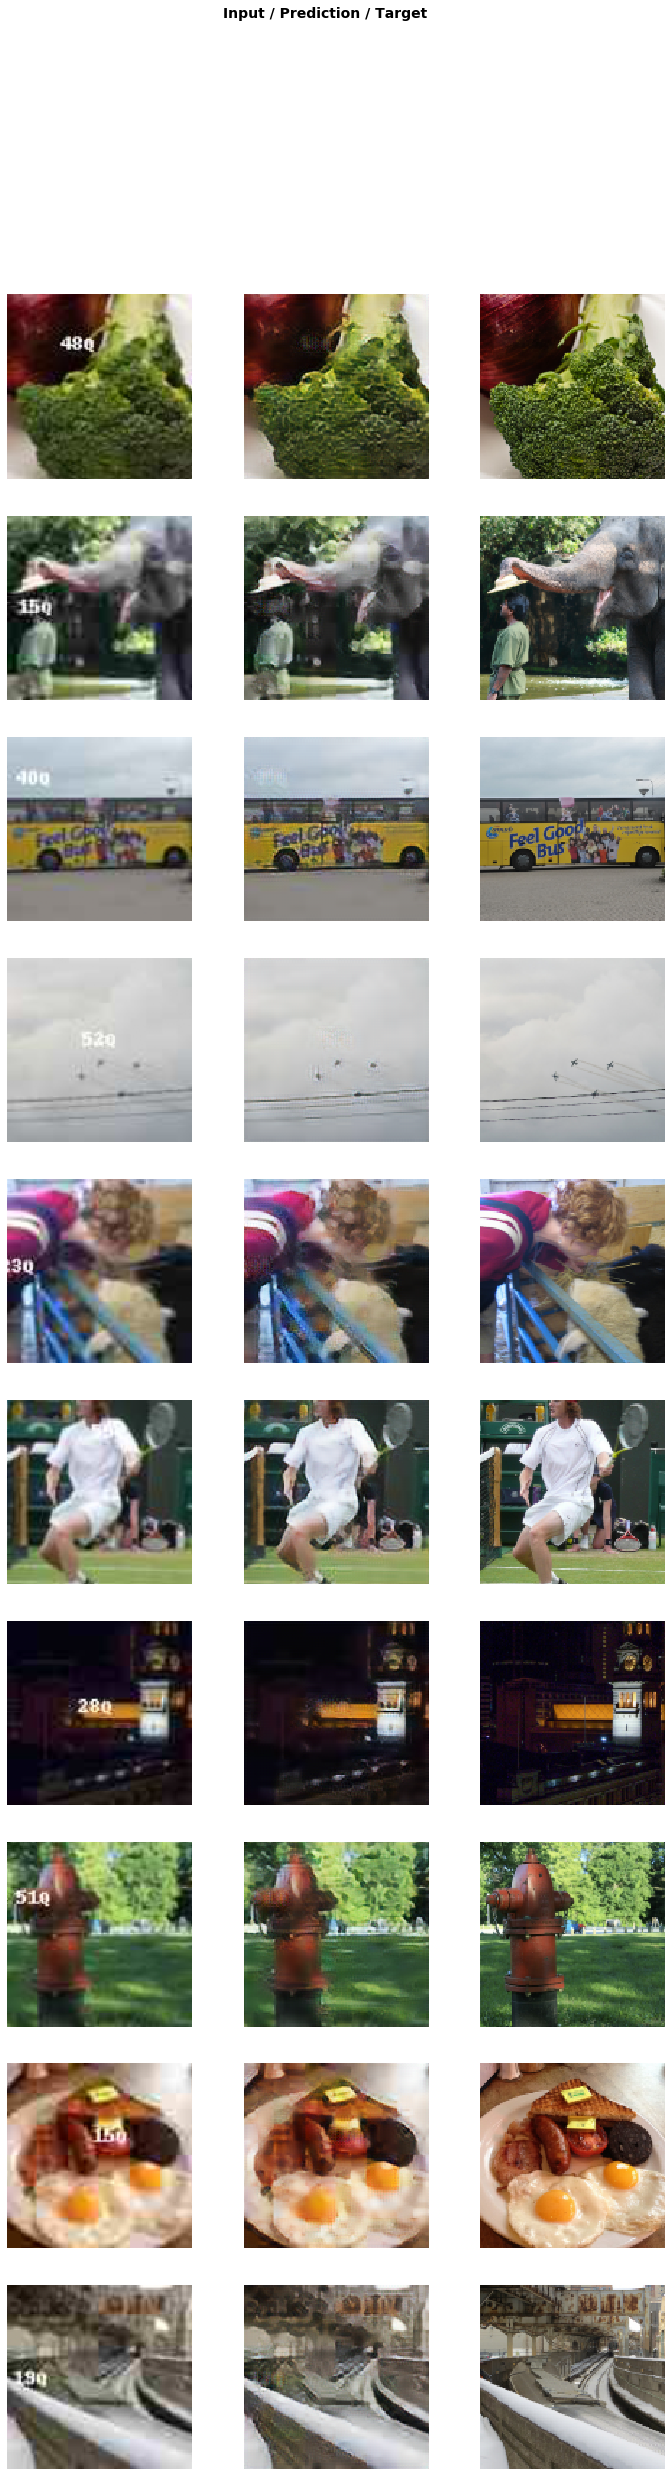

In [89]:
learn.show_results(rows=10)

In [79]:
!ls '/content/data/image_gen' | head -1

000000000009.jpg


In [0]:
%cd '/content/data/bloop'
!wget "https://www.google.com/url?sa=i&url=https%3A%2F%2Fcloudinary.com%2Fblog%2Fautomatic_image_sharpening_and_blurring_in_the_cloud&psig=AOvVaw3LgLwoIcTRcdCZQfKEV5T-&ust=1573842516418000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCIiktreq6uUCFQAAAAAdAAAAABAD"

In [0]:
img_test = open_image(path/'bloop'/'hd.jpg')


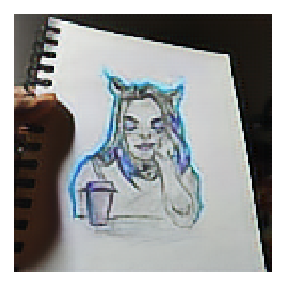

In [96]:
show_image(img_test, figsize=(5,5), interpolation='nearest');

In [0]:
_,img_hr,b = learn.predict(img_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


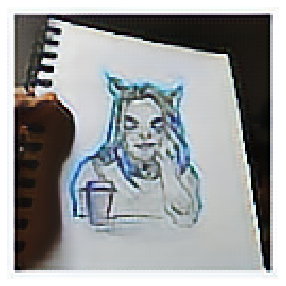

In [98]:
Image(img_hr).show(figsize=(5,5))